In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!git clone https://github.com/musheera2/underwater_image_enhancement.git

Cloning into 'underwater_image_enhancement'...
remote: Enumerating objects: 11751, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 11751 (delta 0), reused 0 (delta 0), pack-reused 11746
Receiving objects: 100% (11751/11751), 264.53 MiB | 33.74 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (11744/11744), done.


In [3]:
import pandas as pd
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,MaxPooling2D,Dropout,BatchNormalization,MaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import load_img
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing.image import img_to_array
from keras import applications

In [4]:
DATASET="./underwater_image_enhancement/Dataset/Train/"

CATEGORIES=["Corals", "Crabs", "Dolphin", "Eel", "Jelly Fish", "Lobster", "Nudibranchs", "Octopus", "Penguin", "Puffers", "Sea Rays", "Sea Urchins", "Seahorse", "Seal", "Sharks", "Squid", "Starfish", "Turtle_Tortoise", "Whale"]
#ten types of leaf diseases       
train_data=[]

for category in CATEGORIES:
        label=CATEGORIES.index(category)
        path=os.path.join(DATASET,category)
        for img_file in random.choices(os.listdir(path),k=450):
            img=cv.imread(os.path.join(path,img_file),1)
            img=cv.cvtColor(img,cv.COLOR_BGR2RGB)
            img=cv.resize(img,(128,128))            
            train_data.append([img,label])

In [5]:
DATASET="underwater_image_enhancement/Dataset/Test/"

CATEGORIES=["Corals", "Crabs", "Dolphin", "Eel", "Jelly Fish", "Lobster", "Nudibranchs", "Octopus", "Penguin", "Puffers", "Sea Rays", "Sea Urchins", "Seahorse", "Seal", "Sharks", "Squid", "Starfish", "Turtle_Tortoise", "Whale"]
#ten types of leaf diseases       
test_data=[]

for category in CATEGORIES:
        label=CATEGORIES.index(category)
        path=os.path.join(DATASET,category)
        for img_file in random.choices(os.listdir(path),k=100):
            img=cv.imread(os.path.join(path,img_file),1)
            img=cv.cvtColor(img,cv.COLOR_BGR2RGB)
            img=cv.resize(img,(128,128))            
            test_data.append([img,label])

In [6]:
print(f"The shape of the Training Data:\n")
train_data[0][0].shape

The shape of the Training Data:



(128, 128, 3)

In [7]:
val_data=[]
DATASET="./underwater_image_enhancement/Dataset/Val/"

CATEGORIES=["Corals", "Crabs", "Dolphin", "Eel", "Jelly Fish", "Lobster", "Nudibranchs", "Octopus", "Penguin", "Puffers", "Sea Rays", "Sea Urchins", "Seahorse", "Seal", "Sharks", "Squid", "Starfish", "Turtle_Tortoise", "Whale"]
for category in CATEGORIES:
        label=CATEGORIES.index(category)
        path=os.path.join(DATASET,category)
        for img_file in random.choices(os.listdir(path),k=100):
            img=cv.imread(os.path.join(path,img_file),1)
            img=cv.cvtColor(img,cv.COLOR_BGR2RGB)
            img=cv.resize(img,(128,128))
            val_data.append([img,label])
            
print(len(train_data)) # size of train dataset
print(len(test_data))
print(len(val_data))# size of validation dataset

8550
1900
1900


In [8]:
import random

random.shuffle(train_data)
random.shuffle(test_data)

    
X_train=[]
y_train=[]

for features,label in train_data:
    X_train.append(features)
    y_train.append(label)

In [9]:
X_test=[]
y_test=[]

for features,label in test_data:
    X_test.append(features)
    y_test.append(label)

In [10]:
X_val=[]
y_val=[]

for features,label in val_data:
    X_val.append(features)
    y_val.append(label)
    

# Reshaping and Normalizing the Data

In [11]:
X_train=np.array(X_train).reshape(-1,128,128,3)
X_train=X_train/255.0
print(X_train.shape)

X_test=np.array(X_test).reshape(-1,128,128,3)
X_test=X_test/255.0
print(X_test.shape)

X_val=np.array(X_val).reshape(-1,128,128,3)
X_val=X_val/255.0
print(X_val.shape)

(8550, 128, 128, 3)
(1900, 128, 128, 3)
(1900, 128, 128, 3)


In [12]:
y_train=to_categorical(y_train)


y_test=to_categorical(y_test)
y_val = to_categorical(y_val)

In [14]:
from keras import applications
from keras.applications.inception_v3 import InceptionV3
import warnings
warnings.filterwarnings("ignore")

img_height,img_width = 128,128 
num_classes = 19
#If imagenet weights are being loaded, 
#input must have a static square shape (one of (128, 128), (160, 160), (192, 192), or (224, 224))
base_model = InceptionV3(weights= None, include_top=False, input_shape= (img_height,img_width,3))

In [15]:
from tensorflow.keras.models import Model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(120, activation='relu')(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

In [16]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 63, 63, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 63, 63, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 63, 63, 32)   0           batch_normalization_94[0][0]     
______________________________________________________________________________________________

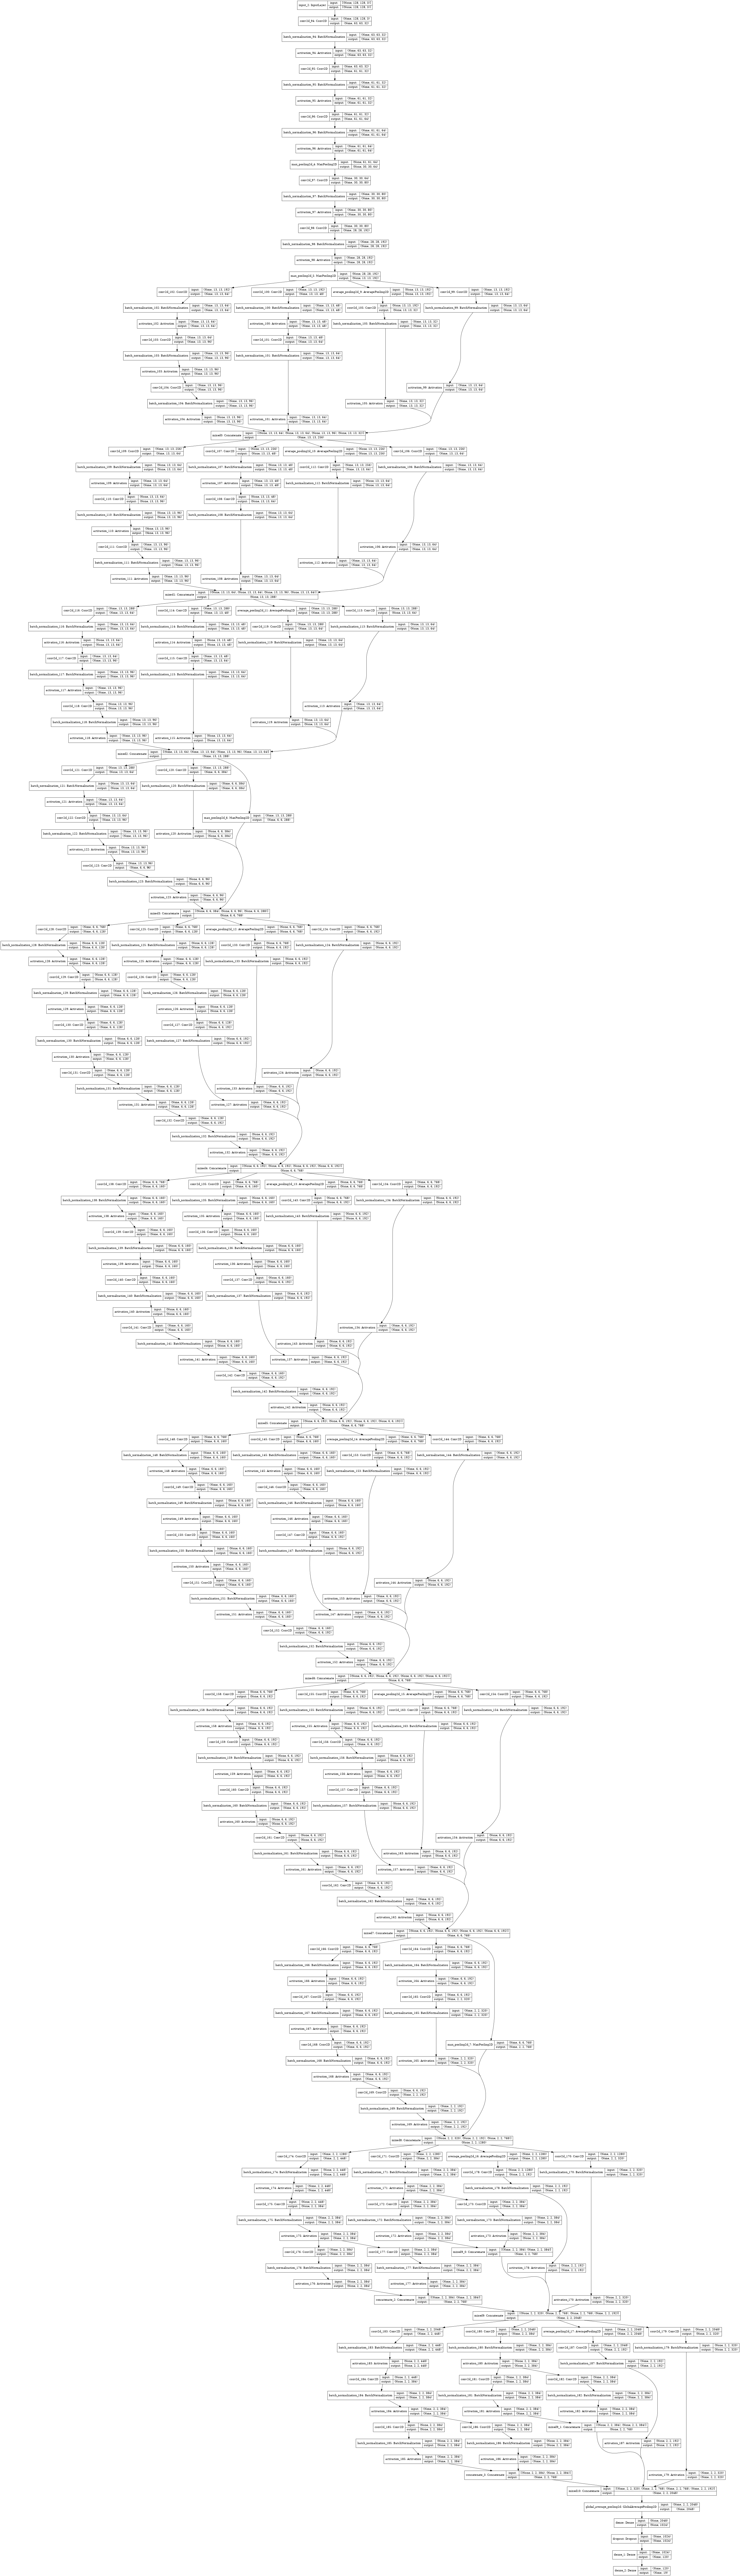

In [17]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

model_checkpoint = ModelCheckpoint(
    filepath="InceptionV3_model_on_underwater.h5",
    verbose=3,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# early_stopping= EarlyStopping(monitor="val_loss",patience=4,verbose=3,mode="min")

reducelrplateau= ReduceLROnPlateau(monitor='val_loss', factor=0.2,verbose=3,patience=1,mode="min", min_lr=0.0001)


hist=model.fit(X_train,y_train,epochs=100,batch_size=128,validation_split=0.2,callbacks= [model_checkpoint,reducelrplateau])

2023-01-22 14:18:57.656933: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1344798720 exceeds 10% of free system memory.
2023-01-22 14:18:59.328523: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1344798720 exceeds 10% of free system memory.
2023-01-22 14:19:00.500525: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2023-01-22 14:19:09.053264: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


54/54 [==============================] - ETA: 0s - loss: 2.9126 - accuracy: 0.1054

2023-01-22 14:19:43.112327: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 336199680 exceeds 10% of free system memory.
2023-01-22 14:19:43.530661: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 336199680 exceeds 10% of free system memory.


54/54 [==============================] - 47s 424ms/step - loss: 2.9126 - accuracy: 0.1054 - val_loss: 3.1449 - val_accuracy: 0.0497

Epoch 00001: val_accuracy improved from -inf to 0.04971, saving model to InceptionV3_model_on_underwater.h5
Epoch 2/100
54/54 [==============================] - 17s 310ms/step - loss: 2.5833 - accuracy: 0.1604 - val_loss: 3.3818 - val_accuracy: 0.0497

Epoch 00002: val_accuracy did not improve from 0.04971

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 3/100
54/54 [==============================] - 17s 316ms/step - loss: 2.4011 - accuracy: 0.2107 - val_loss: 3.4041 - val_accuracy: 0.0480

Epoch 00003: val_accuracy did not improve from 0.04971

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 4/100
54/54 [==============================] - 17s 319ms/step - loss: 2.2293 - accuracy: 0.2556 - val_loss: 2.9484 - val_accuracy: 0.0579

Epoch 00004: val_accuracy improved from 0.04971 to 0.05789, saving

In [23]:
model.load_weights('./InceptionV3_model_on_underwater.h5')

In [24]:
test_loss,test_acc=model.evaluate(X_test,y_test)
print("\n\n InceptionV3 Accuracy:")
test_loss,test_acc

2023-01-22 14:50:12.736010: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 373555200 exceeds 10% of free system memory.


60/60 [==============================] - 4s 43ms/step - loss: 4.2912 - accuracy: 0.3126


 InceptionV3 Accuracy:


(4.291167736053467, 0.3126315772533417)

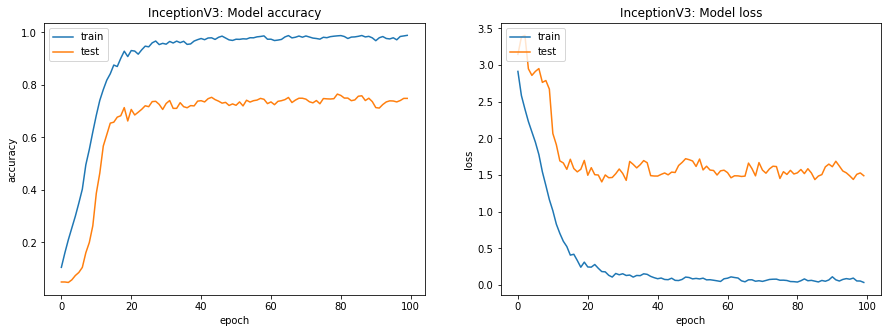

In [25]:
# Plot the accuracy and loss curves
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('InceptionV3: Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('InceptionV3: Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
y_pred=model.predict(X_test)
y_pred=np.argmax(y_pred,axis=1)
y_test= np.argmax(y_test,axis=-1)

In [27]:
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

In [24]:
cm=confusion_matrix(y_test,y_pred)
cm

array([[ 93,   2,   0,   1,   1,   0,   0,   0,   0,   3],
       [ 10,  64,   0,  11,   2,   5,   3,   4,   0,   1],
       [  0,   0, 100,   0,   0,   0,   0,   0,   0,   0],
       [  2,   8,   0,  80,   2,   2,   1,   1,   0,   4],
       [  3,   2,   0,   1,  91,   3,   0,   0,   0,   0],
       [  0,   0,   3,   3,   2,  91,   0,   1,   0,   0],
       [  0,   2,   0,   0,   0,   0,  87,   9,   2,   0],
       [  1,   6,   1,   1,   0,   0,   6,  84,   1,   0],
       [  0,   0,   0,   0,   2,   3,   0,   0,  95,   0],
       [  1,   0,   0,   1,   0,   0,   0,   0,   0,  98]])

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='InceptionV3: Confusion matrix',
                          cmap=plt.cm.YlOrRd):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=17)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="right",
                 color="White" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


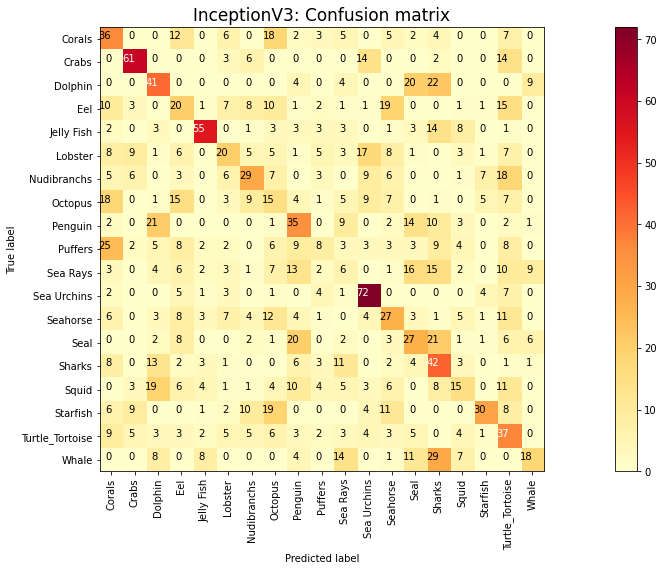

In [29]:
import itertools
plt.figure(figsize=(20,7))
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes=CATEGORIES)
plt.xticks(rotation=90)
plt.savefig("InceptionV3 : Confusion_matrix.jpg")

In [30]:
from sklearn.metrics import classification_report
print("InceptionV3: Classification Report\n\n")
print(classification_report(y_test,y_pred,target_names=CATEGORIES))

InceptionV3: Classification Report


                 precision    recall  f1-score   support

         Corals       0.26      0.36      0.30       100
          Crabs       0.62      0.61      0.62       100
        Dolphin       0.33      0.41      0.37       100
            Eel       0.20      0.20      0.20       100
     Jelly Fish       0.67      0.55      0.60       100
        Lobster       0.29      0.20      0.24       100
    Nudibranchs       0.36      0.29      0.32       100
        Octopus       0.13      0.15      0.14       100
        Penguin       0.29      0.35      0.32       100
        Puffers       0.20      0.08      0.11       100
       Sea Rays       0.08      0.06      0.07       100
    Sea Urchins       0.51      0.72      0.60       100
       Seahorse       0.26      0.27      0.26       100
           Seal       0.25      0.27      0.26       100
         Sharks       0.24      0.42      0.30       100
          Squid       0.26      0.15      0.19    

In [28]:
y_test[23]

5

Predicted Label:
[0]---> Corals


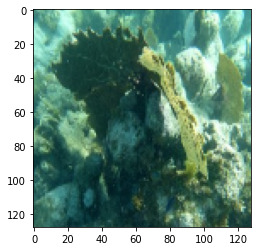

In [31]:
sample_pred=model.predict(np.array(X_test[23]).reshape(-1,128,128,3))
sample_pred = np.argmax(sample_pred, axis=-1)
print("Predicted Label:")
plt.imshow(X_test[23])
print(sample_pred,end="---> ")
print(CATEGORIES[sample_pred[0]])

In [32]:
lis=[]
for image,true,pred in zip(X_test,y_test,y_pred):
    lis.append([image,true,pred])
    

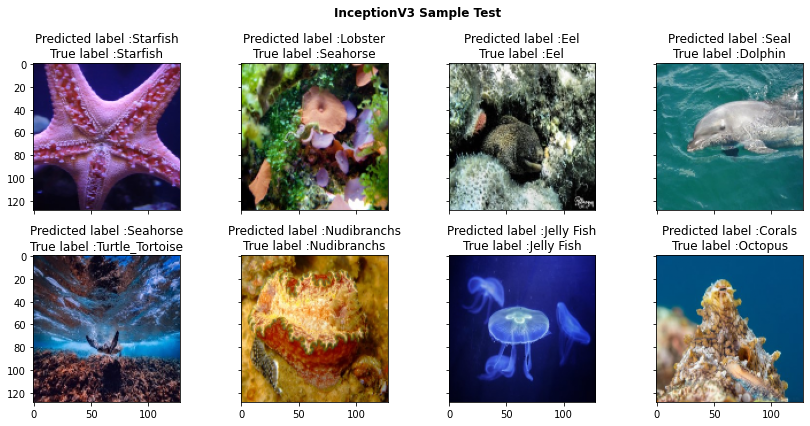

<Figure size 936x432 with 0 Axes>

In [37]:
#Monitoring the model_performance with its predictions and labels
plt.rcParams["figure.figsize"] = (13,6)
n = 0
nrows = 2
ncols = 4

fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
fig.suptitle("InceptionV3 Sample Test",fontweight ="bold")
for row in range(nrows):
    for col in range(ncols):

        test_image,true_label,pred_label = random.choice(lis) #Make Sure your test image size would be (-1,128,128,3)
        
        ax[row,col].imshow(test_image)
#         sample_pred =  model.predict(np.array(test_image).reshape(-1,128,128,3))
        pred_label = pred_label
        ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(CATEGORIES[pred_label],CATEGORIES[true_label]))
        n += 1
        plt.tight_layout()
plt.show()
plt.savefig("InceptionV3_Sample_Test.jpg")


# Testing on Train

In [38]:
train_acc= model.predict(X_train)

Confusion matrix, without normalization


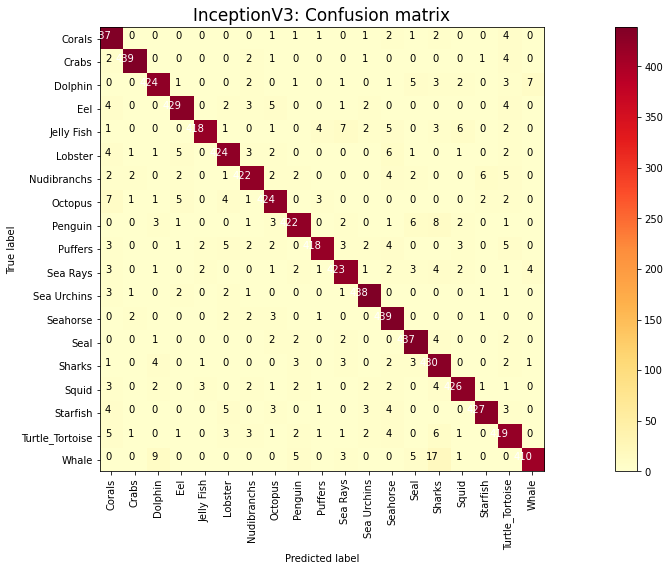

In [39]:
train_pred=np.argmax(train_acc,axis=-1)
train_test= np.argmax(y_train,axis=-1)

#plot Confusion matrix
import itertools
plt.figure(figsize=(20,7))
cm_train = confusion_matrix(train_test,train_pred)
plot_confusion_matrix(cm_train, classes=CATEGORIES)
plt.xticks(rotation=90)
plt.savefig("InceptionV3 : Train Confusion_matrix.jpg")

In [40]:
from sklearn.metrics import classification_report
print("\nInceptionV3: TEST Classification Report\n")
print(classification_report(train_test,train_pred,target_names=CATEGORIES))


InceptionV3: TEST Classification Report

                 precision    recall  f1-score   support

         Corals       0.91      0.97      0.94       450
          Crabs       0.98      0.98      0.98       450
        Dolphin       0.95      0.94      0.95       450
            Eel       0.96      0.95      0.96       450
     Jelly Fish       0.98      0.93      0.95       450
        Lobster       0.94      0.94      0.94       450
    Nudibranchs       0.95      0.94      0.94       450
        Octopus       0.94      0.94      0.94       450
        Penguin       0.95      0.94      0.95       450
        Puffers       0.97      0.93      0.95       450
       Sea Rays       0.95      0.94      0.94       450
    Sea Urchins       0.96      0.97      0.97       450
       Seahorse       0.92      0.98      0.95       450
           Seal       0.94      0.97      0.96       450
         Sharks       0.89      0.96      0.92       450
          Squid       0.96      0.95      0.9

In [ ]:
train_loss,train_acc=model.evaluate(X_train,y_train)
print("\n\nTEST ACCURACY:")
train_loss,train_acc